# Forecasting
This Notebook reads pre-processed predictor (SWE PC) and predictand (Q volumes) data and builds an Ordinary Least Squares (OLS) regression model to produce hindcasts (forecasts for the past) of the predictand. We use the statsmodels Python module to do the statistical modelling. More information about statsmodels can be found [here](https://www.statsmodels.org/stable/index.html). Note that in this workflow we might use the terms forecast and hindcast interchangeably as they would be generated the same way with this method, but either for the future or in hindsight, respectively.

Decisions:
- We do not look at input data stationarity.
- We assume that the flow accumulation periods have a moving start date and the same end date (e.g., Jan-Sep, Feb-Sep, Mar-Sep, ...)
- We perform a split sample testing to train the forecast model on the first half of the dataset and test it on the second half (see split_sample function below).
- We are keeping all data available, but we could decide to discard extreme years for training the forecast model, as including them could skew the results.
- We use the first SWE PC only as a predictor for forecasting (see user-specified variables below). If using more PCs, we should be careful with overfitting when the dataset has a few years compared to the number of PCs.
- The PC(s) used as as predictors are prescribed. If we wish to select the optimal PCs for forecasting, this has to be implemented (some starting code can be found in the "forecasting_old.ipynb" on Louise Arnal's computer).
- We use an OLS regression model.
- Hindcasts with 100 ensemble members are generated (see user-specified variables below).
- The ensemble members are generated with an even distribution (vs. random; see user-specified variables below).

# Modules, paths, variables & functions
Paths & variables are the only elements you should need to modify.

In [1]:
# Import required modules
import numpy as np
import pandas as pd
import xarray as xr
import datetime
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
from scipy.stats import norm

In [2]:
# Set user-specified variables
PC_no_default, PC_id_default = 1, 'PC1'  # integer > 0 for the number of principal components of SWE to use for the forecasting, and string of the PC to use (if PC_no > 1, PC_id should be a list of strings)
target_period_start_month, target_period_end_month = np.arange(1,9+1), 9  # starting and end months of volume accumulation periods
predictor_month_demo, predictand_start_month_demo, predictand_end_month_demo, year_demo = 5, 6, 9, 2013  # forecast start date, target period, and year (year only used for plotting) to use for the forecasting workflow step-by-step demonstration
min_obs_corr_default = 3 # minimum number of observations required to calculate the correlation between predictand-predictor
min_overlap_years_default = 10 # minimum number of years required of PC-volume to be able to generate a forecast
nyears_leaveout_default = 1 # number of years to leave out at a time for forecast cross-validation
method_traintest_default = 'leave_out' # method to use for the cross-validation ('leave_out': leave nyears_leaveout_default years out or 'split_sample': 1st half used for training and 2nd half for testing)
ens_size_default = 100  # integer > 0 for the number of forecast ensemble members to generate
method_ensemble_dressing_default = 'even'  # string defining the method to choose to generate these ensemble members (options are 'even' or 'random')

In [3]:
def predictor_predictand_corr_plot(predictor_data, predictand_data, PC_id, start_months, end_month, min_obs_corr):
    
    """Calculates and plots correlations between a SWE PC (predictor) & flow volumes (predictand) for different lead times and for different volume accumulation periods.
    
    Keyword arguments:
    ------------------
    - predictor_data: Pandas DataFrame of the predictor (SWE PC) data
    - predictand_data: Pandas DataFrame of the predictand (flow columes) data
    - PC_id: String of the PC to use for the predictor data
    - start_months: List of integers of the starting months of volume accumulation periods (predictand)
    - end_month: Integer of the end month of volume accumulation periods (predictand)
    - min_obs_corr: Positive integer defining the minimum number of observations required to calculate the correlation between predictand-predictor
    
    Returns:
    --------
    - correlations: Pandas DataFrame of the correlations between predictors and predictands
    - A matrix plot of the correlations between predictors and predictands
    
    """

    # Initialize empty Numpy array to store correlations between predictors & predictands
    corr_array = np.ones((len(start_months),len(start_months))) * np.nan
    
    # Initialize predictand and predictor indices for saving the correlations & plotting
    predictand_idx = []
    predictor_idx = []

    # Set the name of the end month of the predictand's accumulation periods - e.g., 'Sep' for month 9
    predictand_end_month_name = datetime.datetime.strptime(str(end_month), "%m").strftime("%b")

    # Initialize counter for saving & plotting data
    elem_row = -1

    # Loop over predictor dates
    for predictor_month in start_months:

        # update counters for saving & plotting data
        elem_row += 1
        elem_col = elem_row - 1

        # save the predictor indices to empty list
        predictor_month_name = datetime.datetime.strptime(str(predictor_month), "%m").strftime("%b")
        predictor_idx.append(predictor_month_name)

        # loop over predictand accumulation periods start dates
        for predictand_start_month in range(predictor_month, end_month+1):
            
            # update counters for saving & plotting data
            elem_col += 1 
            
            # set the name of the starting month of the predictand's accumulation periods - e.g., 'Sep' for month 9
            predictand_start_month_name = datetime.datetime.strptime(str(predictand_start_month), "%m").strftime("%b")

            # save the predictand label to empty list
            if elem_row == 0:
                predictand_idx.append(predictand_start_month_name+'-'+predictand_end_month_name)
            
            # get predictor & predictand series for overlapping time period
            SWE_data = predictor_data[(predictor_data.index.month == predictor_month) & (predictor_data.index.day == 1)][PC_id]
            SWE_data = SWE_data.dropna()
            new_index = SWE_data.index.year
            SWE_data = pd.Series(SWE_data.values, name='SWE', index=pd.Index(new_index, name='year'))
            flow_data = predictand_data['Vol_'+predictand_start_month_name+'-'+predictand_end_month_name].rename('Qobs')

            # calculate correlations between predictor & predictand and save results to Numpy array
            corr_value = round(SWE_data.corr(flow_data, method='pearson', min_periods=min_obs_corr)**2,2)
            corr_array[elem_row, elem_col] = corr_value

    # Save correlations Numpy array as Pandas DataFrame
    correlations = pd.DataFrame(data=corr_array, index=predictor_idx, columns=predictand_idx)

    # Plot matrix of correlations
    cmap = sns.cm.rocket_r
    ax = sns.heatmap(correlations, annot=True, cmap=cmap, cbar_kws={'label': 'R$^2$'}, vmin=0, vmax=1)
    ax.set(xlabel="Flow accumulation periods", ylabel = "SWE dates (1st)")
    
    return correlations

In [4]:
def combine_SWE_flow_timeseries(predictor_data, predictand_data):
    
    """Combines predictor & predictand data.
    
    Keyword arguments:
    ------------------
    - predictor_data: Pandas DataFrame of the predictor (SWE PCs) data
    - predictand_data: Pandas DataFrame of the predictand (flow columes) data
    
    Returns:
    --------
    - combined_data: Pandas DataFrame of combined predictor & predictand data
    
    """

    # Extract predictor data for specified month
    SWE_data = predictor_data 
    SWE_data = SWE_data.dropna(axis=1)
    new_index = SWE_data.index.year
    SWE_data = SWE_data.reset_index(drop=True)
    SWE_data['year'] = new_index
    SWE_data = SWE_data.set_index('year')
    
    # Combine predictor & predictand into a single Pandas DataFrame
    combined_data = SWE_data    
    combined_data['Vol'] = predictand_data
    combined_data = combined_data.dropna(axis=0, how='any')
    
    return combined_data

In [5]:
def split_sample(original_timeseries):
    
    """Splits predictor & predictand timeseries data in half for split sample testing (training & testing the forecast model).
    
    Keyword arguments:
    ------------------
    - original_timeseries: Pandas DataFrame of the combined predictor & predictand timeseries
    
    Returns:
    --------
    - train_timeseries: Pandas DataFrame containing the 1st half of the timeseries used for training the forecast model
    - test_timeseries: andas DataFrame containing the 2nd half of the timeseries used for testing the forecast model
    
    """

    split_point = int(len(original_timeseries.index)/2)
    train_timeseries = original_timeseries[0:split_point]
    test_timeseries = original_timeseries[split_point:]
    
    return train_timeseries, test_timeseries

In [6]:
def leave_out(original_timeseries, nyears_leaveout):
    
    """Splits predictor & predictand timeseries data using leave years out method (training & testing the forecast model).
    E.g., if nyears_leaveout = 1, we leave one year out each time for which we want to test (i.e., validate) the model. All other years will be used for training the model.
    If nyears_leaveout = 3, we leave 3 successive years out at a time.
    
    Keyword arguments:
    ------------------
    - original_timeseries: Pandas DataFrame of the combined predictor & predictand timeseries
    - nyears_leaveout: Integer above zero for the number of years to leave out at a time
    
    Returns:
    --------
    - train_timeseries: Pandas DataFrame containing the 1st half of the timeseries used for training the forecast model
    - test_timeseries: Pandas DataFrame containing the 2nd half of the timeseries used for testing the forecast model
    
    """  

    n_examples = len(original_timeseries)
    test_dict = {}
    train_dict = {}
    k=0
    remainder = n_examples % nyears_leaveout

    while(k * nyears_leaveout + nyears_leaveout <= n_examples):
        test_samples = list(range(k * nyears_leaveout,k * nyears_leaveout + nyears_leaveout))
        test_dict[k] = original_timeseries.iloc[test_samples]
        train_samples = [x for x in list(range(n_examples)) if x not in test_samples]
        train_dict[k] = original_timeseries.iloc[train_samples]
        k+=1

    if remainder != 0:
        test_samples = list(range(n_examples-remainder,n_examples))
        test_dict[k] = original_timeseries.iloc[test_samples]
        train_samples = [x for x in list(range(n_examples)) if x not in test_samples]
        train_dict[k] = original_timeseries.iloc[train_samples]
    
    return train_dict, test_dict

In [7]:
def OLS_model_fitting(PC_ids, train_timeseries):
    
    """Fits the OLS model using the specified predictor(s) and training data.
    
    Keyword arguments:
    ------------------
    - PC_ids: String (if only 1) or list (if more than 1) of the PC(s) to use as predictor data
    - train_timeseries: Pandas DataFrame containing the predictor & predictand data to use for training the forecast model
    
    Returns:
    --------
    - model_fit: OLS model
    
    """
    
    # Initialize formula used in the forecast model
    formula = 'Vol ~ '

    # Build formula by adding predictor(s)
    # If more than one predictor
    if type(PC_ids) == list:
        
        # make sure PC we're calling exists in the dataset
        PCs_to_use = tuple(set.intersection(set(train_timeseries.columns.values), set(tuple(PC_ids))))
                
        # add PC to formula
        formula += PCs_to_use[0]
        for pc in PCs_to_use[1::]:
            formula += ' + ' + pc
    
    # If only one predictor
    else:      
        formula += PC_ids

    # Fit OLS model on the training dataset
    OLS_model = smf.ols(formula=formula, data=train_timeseries)
    model_fit = OLS_model.fit()

    return model_fit

In [8]:
def deterministic_forecasting(model, test_timeseries):
    
    """Out-of-sample forecasting based on the test data predictor(s) and the model developed on the training data.
    
    Keyword arguments:
    ------------------
    - model: Regression model from statsmodels developed on the training data
    - test_timeseries: Pandas DataFrame containing the predictor & predictand data to use for testing the forecast model
    
    Returns:
    --------
    - flow_fc_mean: Pandas Dataframe containing the flow forecast means
    
    """

    # Generate out-of-sample forecasts based on the test data predictor(s)
    forecast = model.get_prediction(exog=test_timeseries)

    # Save the forecast mean to a Pandas DataFrame
    flow_fc_mean = pd.DataFrame(forecast.predicted_mean, index=test_timeseries.index, columns=["Vol_fc_mean"])

    # Set all negative forecast values to 0 as we don't want negative data
    flow_fc_mean[flow_fc_mean < 0] = 0
    
    return flow_fc_mean

In [9]:
def deterministic_forecast_plots(obs_timeseries, det_fc_timeseries, predictor_month, predictand_start_month, predictand_end_month, units):
    
    """Plot deterministic forecasts.
    
    Keyword arguments:
    ------------------
    - obs_timeseries: Pandas DataFrame of the observed flow accumulation data
    - det_fc_timeseries: Pandas DataFrame of the deterministic forecasts of flow accumulation
    - predictor_month: Integer of the month of predictor data to use 
    - predictand_start_month: Integer of the starting month of predictand data to use
    - predictand_end_month: Integer of the end month of predictand data to use
    - units: string of the flow units to use on the plot
    
    Returns:
    --------
    - Timeseries and scatter plots of the flow accumulation deterministic forecasts and observations
    
    """

    # Select observed data that matches the forecast period
    obs_data = obs_timeseries.loc[det_fc_timeseries.index]
    
    # Initialize figure
    fig = plt.figure(figsize=(20, 5))
    layout = (1,3)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    scatter_ax = plt.subplot2grid(layout, (0,2))

    # Timeseries plot of deterministic forecasts and observations
    ts_ax.plot(obs_data.index, obs_data.values, color='red', label='observations', marker='o')
    ts_ax.plot(det_fc_timeseries.index, det_fc_timeseries['Vol_fc_mean'].values, color='blue', label='deterministic forecasts', marker='o')
    ts_ax.set_ylabel('Flow accumulation '+predictand_start_month+'-'+predictand_end_month+' ['+units+']')
    ts_ax.set_xticks(obs_data.index)
    ts_ax.legend()
    ts_ax.set_title('Forecasts initialized on 1st '+predictor_month)

    # Scatter plot of deterministic forecasts vs observations
    scatter_ax.scatter(obs_data.values, det_fc_timeseries['Vol_fc_mean'].values, color='k')
    min_value = min(obs_data.min(),det_fc_timeseries['Vol_fc_mean'].min())
    max_value = max(obs_data.max(),det_fc_timeseries['Vol_fc_mean'].max())
    scatter_ax.plot([min_value,max_value], [min_value,max_value], color='k', alpha=.3, ls='--')
    scatter_ax.set_xlabel('Observations'+' ['+units+']')
    scatter_ax.set_ylabel('Deterministic forecasts'+' ['+units+']')
    scatter_ax.set_title('Forecasts initialized on 1st '+predictor_month);

In [10]:
def ensemble_forecast_plots(obs_timeseries, ens_fc_timeseries, predictor_month, predictand_start_month, predictand_end_month, units):

    """Plot ensemble forecasts.
    
    Keyword arguments:
    ------------------
    - obs_timeseries: Pandas DataFrame of the observed flow accumulation data
    - ens_fc_timeseries: Pandas DataFrame of the ensemble forecasts of flow accumulation
    - predictor_month: Integer of the month of predictor data to use 
    - predictand_start_month: Integer of the starting month of predictand data to use
    - predictand_end_month: Integer of the end month of predictand data to use
    - units: string of the flow units to use on the plot
    
    Returns:
    --------
    - Timeseries plot of the flow accumulation ensemble forecasts and observations
    
    """
    
    # Select observed data that matches the forecast period
    obs_data = obs_timeseries.loc[ens_fc_timeseries.index]
        
    # Initialize figure
    fig = plt.figure(figsize=(20, 5))
    ts_ax = plt.subplot()

    # Timeseries plot of ensemble forecasts and observations
    reddots, = ts_ax.plot(np.arange(1, len(obs_data)+1), obs_data.values, color='red', label='observations', marker='o')
    bp = plt.boxplot(ens_fc_timeseries, patch_artist=True, zorder=1, whis=[0, 100], showfliers=False)
    plt.setp(bp['boxes'], color='b', alpha=.5)
    plt.setp(bp['whiskers'], color='b')
    plt.setp(bp['medians'], color='k')
    bluepatch = mpatches.Patch(color='b', alpha=.5, label='ensemble forecasts')
    ts_ax.set_ylabel('Flow accumulation '+predictand_start_month+'-'+predictand_end_month+' ['+units+']')
    ts_ax.set_xticklabels(obs_data.index.values)
    plt.legend(handles=[reddots,bluepatch])
    ts_ax.set_title('Forecasts initialized on 1st '+predictor_month);

In [11]:
def ensemble_dressing(det_fc, SD, ens_size, method):
    
    """Generate ensembles around deterministic forecasts. Ensembles can have an evenly spaced distribution or be randomly distributed.
    
    Keyword arguments:
    ------------------
    - det_fc: Pandas DataFrame of the deterministic forecasts
    - SD: Positive value of the standard deviation of errors between the forecast means and observed values during training
    - ens_size: Integer > 0 of the number of ensemble members to generate
    - method: String to define the method used to distribute the ensemble members: 'even' or 'random'
    
    Returns:
    --------
    - ens_fc: Pandas DataFrame of the ensemble forecasts produced
    
    """

    # Initialize empty Numpy array to store the ensemble member values
    ensembles = np.zeros((len(det_fc.index), ens_size))

    # Initialize the z-scores used to generate ensemble member values within the distribution
    pvalues = np.linspace(0.01,0.99,ens_size)
    zscores = norm.ppf(pvalues)

    # Loop over forecasts
    for x in range(len(det_fc.index)):

        # for evenly spaced ensemble members
        if method == 'even':
            ensembles[x,:] = zscores * SD + det_fc['Vol_fc_mean'].values[x]

        # for randomly spaced ensemble members
        elif method == 'random':
            ensembles[x,:] = np.random.normal(loc=det_fc['Vol_fc_mean'].values[x], scale=SD, size=ens_size)

    # Save ensemble forecasts to Pandas DataFrame
    ens_fc = pd.DataFrame(data=ensembles, index=det_fc.index, columns=np.arange(1,ens_size+1))
    
    # Set all negative forecast values to 0
    ens_fc[ens_fc < 0] = 0
    
    return ens_fc

In [19]:
def ensemble_forecasting(predictor_data, predictand_data, start_months, end_month, PC_ids, ens_size, method_ensemble_dressing, min_overlap_years, method_traintest, nyears_leaveout):
    
    """Generate ensemble forecasts of flow accumulations (predictand) from SWE PC(s) (predictors).
    
    Keyword arguments:
    ------------------
    - predictor_data: Pandas DataFrame of the predictor (SWE PCs) data
    - predictand_data: Pandas DataFrame of the predictand (flow columes) data
    - start_months: List of integers of the starting months of volume accumulation periods (predictand)
    - end_month: Integer of the end month of volume accumulation periods (predictand)
    - PC_ids: String (if only 1) or list (if > 1) of the PC(s) to use as predictor data
    - ens_size: Integer > 0 of the number of ensemble members to generate
    - method_ensemble_dressing: String to define the method used to distribute the ensemble members: 'even' or 'random'
    - min_overlap_years: Positive integer indicating the minimum number of years required of PC-volume to be able to generate a forecast
    - method_traintest: String to define the method used to split the data into training and testing samples
    - nyears_leaveout: Integer above zero for the number of years to leave out at a time
    
    Returns:
    --------
    - ens_fc_ds: Xarray Dataset to store all ensemble forecasts generated
    
    """
    
    # Initialize dictionary to store all ensemble forecasts generated
    ens_fc_dict = {}
    
    # Initialize counter to keep track of forecasts generated
    elem = 0

    # Loop over forecasts starting months
    for initmo in start_months:

        # loop over forecasts target period starting months
        for fcmo in range(initmo, end_month+1):
            
            # combine SWE and flow into a single pandas dataframe for a given forecasting start month
            predictors = predictor_data[(predictor_data.index.month == initmo) & (predictor_data.index.day == 1)]
            fcmo_name = datetime.datetime.strptime(str(fcmo), "%m").strftime("%b")
            end_month_name = datetime.datetime.strptime(str(end_month), "%m").strftime("%b")
            predictand = predictand_data['Vol_'+fcmo_name+'-'+end_month_name]
            SWE_flow_data = combine_SWE_flow_timeseries(predictors, predictand)
                
            # if there are less than X years available we go to the next forecast target period
            if len(SWE_flow_data) < min_overlap_years:
                continue
                
            # if there is enough data we can carry on with the forecasting
            else:
                                
                # update counter
                elem += 1
                
                # remaining forecasting steps will depend on the approach selected to split the data into train-test samples
                
                # using the split sample approach
                if method_traintest == 'split_sample':
                    
                    # split the timeseries into training and validation timeseries for forecasting
                    train_data, test_data = split_sample(SWE_flow_data)
                    
                    # fit the model on the training data
                    OLS_model = OLS_model_fitting(PC_ids, train_data)

                    # perform out-of-sample deterministic forecasting for the testing period
                    det_flow_fc = deterministic_forecasting(OLS_model, test_data)

                    # calculate errors standard deviation for the training period
                    det_flow_fc_train = deterministic_forecasting(OLS_model, train_data)
                    errors = det_flow_fc_train['Vol_fc_mean'].values - train_data['Vol'].values
                    std_dev = np.std(errors)

                    # generate ensembles with an evenly (method='even') or randomly (method='random') spaced distribution
                    ens_flow_fc = ensemble_dressing(det_flow_fc, std_dev, ens_size=ens_size, method=method_ensemble_dressing)
                
                    # save ensemble forecasts to xarray Dataset
                    ens_fc_da = xr.DataArray(data=ens_flow_fc.to_numpy().reshape((ens_flow_fc.to_numpy().shape[0], ens_flow_fc.to_numpy().shape[1], 1)), coords={'year':ens_flow_fc.index,'ens_member':ens_flow_fc.columns,'init_month':[initmo]}, dims=['year','ens_member','init_month'], name='Vol_'+fcmo_name+'-'+end_month_name)
                
                # or the leave X years out approach
                elif method_traintest == 'leave_out':
                    
                    # split the timeseries into training and validation timeseries for forecasting
                    train_data_dict, test_data_dict = leave_out(SWE_flow_data, nyears_leaveout)
                
                    # loop over the samples
                    for s in list(train_data_dict.keys()):
                        
                        train_data = train_data_dict[s]
                        test_data = test_data_dict[s]
                        
                        # fit the model on the training data
                        OLS_model = OLS_model_fitting(PC_ids, train_data)

                        # perform out-of-sample deterministic forecasting for the testing period
                        det_flow_fc = deterministic_forecasting(OLS_model, test_data)

                        # calculate errors standard deviation for the training period
                        det_flow_fc_train = deterministic_forecasting(OLS_model, train_data)
                        errors = det_flow_fc_train['Vol_fc_mean'].values - train_data['Vol'].values
                        std_dev = np.std(errors)

                        # generate ensembles with an evenly (method='even') or randomly (method='random') spaced distribution
                        ens_flow_fc = ensemble_dressing(det_flow_fc, std_dev, ens_size=ens_size, method=method_ensemble_dressing)
                        
                        # append all ensembles generated for each moving window
                        if s == 0:
                            ens_flow_fc_collate = ens_flow_fc
                        else:
                            ens_flow_fc_collate = pd.concat([ens_flow_fc_collate,ens_flow_fc])
                        
                    # save ensemble forecasts to xarray Dataset
                    ens_fc_da = xr.DataArray(data=ens_flow_fc_collate.to_numpy().reshape((ens_flow_fc_collate.to_numpy().shape[0], ens_flow_fc_collate.to_numpy().shape[1], 1)), coords={'year':ens_flow_fc_collate.index,'ens_member':ens_flow_fc_collate.columns,'init_month':[initmo]}, dims=['year','ens_member','init_month'], name='Vol_'+fcmo_name+'-'+end_month_name)
                
                # save ensemble forecasts to xarray Dataset
                ens_fc_da.attrs['long_name'] = 'Ensemble hindcasts of flow volumes'
                ens_fc_da.attrs['info'] = 'The ensemble hindcasts are generated using an Ordinary Least Squares (OLS) regression model, based on principal components of gap filled SWE station observations as predictor ('+(PC_ids)+'). The flow volumes are calculated over the time period:'+fcmo_name+'-'+end_month_name
                ens_fc_da.attrs['units'] = 'm**3'

                if elem == 1:
                    ens_fc_ds = ens_fc_da

                elif elem > 1:
                    ens_fc_ds = xr.merge([ens_fc_ds, ens_fc_da]) 
    
    # Return the hindcasts dataset if at least 1 could be generated
    if 'ens_fc_ds' in locals():
    
        # Add information to the Dataset
        ens_fc_ds.init_month.attrs['long_name'] = 'Hindcast initialization month'
        ens_fc_ds.init_month.attrs['info'] = 'Months of predictor data from which the hindcasts are made. We select predictor data on the 1st day of each month only.'
        ens_fc_ds.ens_member.attrs['long_name'] = 'Ensemble member'
        ens_fc_ds.ens_member.attrs['info'] = 'Ensemble hindcasts were generated to capture a range of future possibilities instead of a single possibility.'
        
        return ens_fc_ds
    
    # Otherwise return nothing
    else:
        
        return None

# Read and format SWE & Q data

In [16]:
# Read pre-processed SWE data from Notebook 3_SWEPreprocessing
%store -r PCs_testbasin

display(PCs_testbasin)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
date,,,,,,,,,,,,,,
1979-01-01,-2.305357,-1.047390,1.282958,-0.194373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-01,0.464928,0.820542,0.720247,0.812048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-01,1.519222,1.859530,-0.609541,0.610601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-01-01,-1.693269,-0.229725,-0.004157,-0.250121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985-01-01,1.369264,-0.530740,-0.532221,-0.499442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-01,0.380436,0.151498,-0.114790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.729677,0.633586,-0.170937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-01,-0.094396,0.195637,-0.097447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Read pre-processed Q data from Notebook 2_DischargePreprocessing
%store -r flow_volumes_testbasin

display(flow_volumes_testbasin)

<xarray.Dataset>
Dimensions:       (Station_ID: 1, year: 171)
Coordinates:
  * year          (year) int64 1850 1851 1852 1853 1854 ... 2017 2018 2019 2020
    lat           (Station_ID) float64 51.17
    lon           (Station_ID) float64 -115.6
  * Station_ID    (Station_ID) object '05BB001'
    Station_Name  (Station_ID) object 'BOW RIVER AT BANFF'
Data variables:
    Vol_Jan-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_Feb-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_Mar-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_Apr-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_May-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_Jun-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_Jul-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_Aug-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan
    Vol_Sep-Sep   (Station_ID, year) float64 nan nan nan nan ... nan nan nan nan

In [17]:
# Format Q data xarray Dataset to Pandas DataFrame for the forecasting
flow_vol_testbasin_df = flow_volumes_testbasin.to_dataframe().reset_index().drop(columns=['lat', 'lon', 'Station_Name', 'Station_ID']).set_index('year')

display(flow_vol_testbasin_df)

,Vol_Jan-Sep,Vol_Feb-Sep,Vol_Mar-Sep,Vol_Apr-Sep,Vol_May-Sep,Vol_Jun-Sep,Vol_Jul-Sep,Vol_Aug-Sep,Vol_Sep-Sep
year,,,,,,,,,
1850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Predictability analysis 
We look at the correlations between the predictors (SWE PC set in user-specified variables) and the predictands (flow volumes accumulations for target periods set in user-specified variables). This gives us an idea of the level of predictability we can hope to achieve with the forecasting.

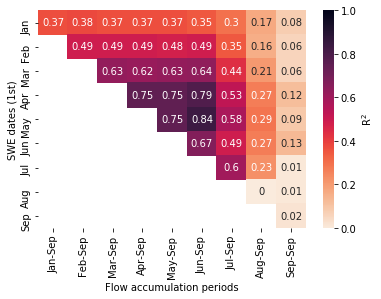

In [16]:
# Calculate & plot the correlations between the predictor(s) & the predictands
if type(PC_id_default) == str:
    correlations_predictor_predictand = predictor_predictand_corr_plot(PCs_testbasin, flow_vol_testbasin_df, PC_id_default, target_period_start_month, target_period_end_month, min_obs_corr=min_obs_corr_default)

elif type(PC_id_default) == list:
    for pc in PC_id_default:
        correlations_predictor_predictand = predictor_predictand_corr_plot(PCs_testbasin, flow_vol_testbasin_df, pc, target_period_start_month, target_period_end_month, min_obs_corr=min_obs_corr_default)

# Forecasting

We perform an Ordinary Least Squares (OLS) regression where the predictors are SWE PC data and the predictands are flow volumes for pre-defined accumulation periods. OLS is a statistical method of analysis that estimates the relationship between one or more independent variables (here the SWE PC) and a dependent variable (here the flow volumes. This method estimates the relationship by minimizing the sum of the squares in the difference between the observed and predicted values, hence the name "Ordinary Least Squares".

## Workflow step-by-step demonstration
Let's go over the forecasting steps for a test forecast start date (the date of the predictor data used for forecasting) and target period (the period we are trying to forecast) to see how it works.

### Predictors & predictand pre-processing

In [22]:
# Months digits to names 
predictor_month_demo_name = datetime.datetime.strptime(str(predictor_month_demo), "%m").strftime("%b")
predictand_start_month_demo_name = datetime.datetime.strptime(str(predictand_start_month_demo), "%m").strftime("%b")
predictand_end_month_demo_name = datetime.datetime.strptime(str(predictand_end_month_demo), "%m").strftime("%b")

In [18]:
# Combine SWE and flow into a single pandas dataframe for a given forecasting start month
predictors = PCs_testbasin[(PCs_testbasin.index.month == predictor_month_demo) & (PCs_testbasin.index.day == 1)]
predictand = flow_vol_testbasin_df['Vol_'+predictand_start_month_demo_name+'-'+predictand_end_month_demo_name]

SWE_flow_data = combine_SWE_flow_timeseries(predictors, predictand)

display(SWE_flow_data.head())

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,Vol
year,,,,,,,,
1971,1.334444,-1.007146,-0.092090,0.352382,-0.178102,-0.011878,0.005082,8.772365e+08
1972,5.630129,-0.090506,0.098722,-0.286957,0.289658,-0.192509,0.391928,1.203604e+09
1973,-0.356144,-0.559954,0.121079,-0.174570,-0.142536,-0.216597,-0.174833,8.105357e+08
1974,3.719423,-0.562604,0.070049,-0.172100,-0.131375,-0.130621,0.055333,1.064794e+09
1979,-1.087291,0.177126,0.358890,0.326431,0.200239,-0.359284,0.093380,7.280237e+08


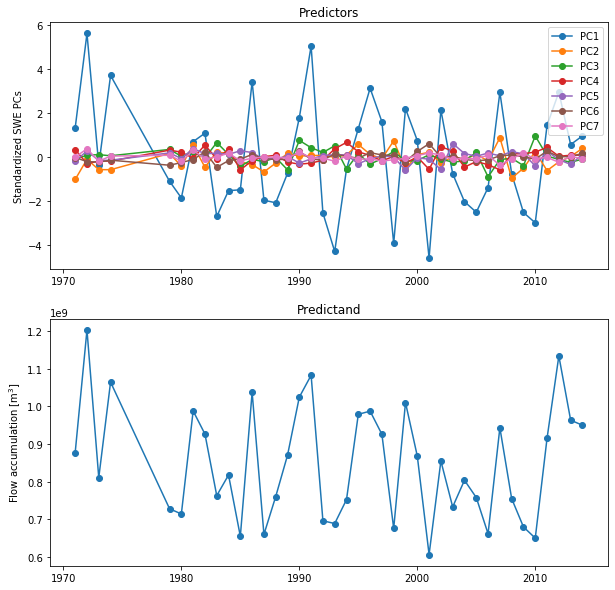

In [19]:
# Plot the SWE and flow data to visually check if they follow a similar temporal behaviors match

# Initialize figure
fig = plt.figure(figsize=(10, 10))
layout = (2,1)
swe_ax = plt.subplot2grid(layout, (0,0))
flow_ax = plt.subplot2grid(layout, (1,0))

# Plot SWE PCs (predictors)
SWE_column_names = [x for x in SWE_flow_data.columns if 'Vol' not in x]
for c in SWE_column_names:
    SWE_flow_data[c].plot(ax=swe_ax, marker='o', label=c)
    swe_ax.set_xlabel('')
    swe_ax.set_ylabel('Standardized SWE PCs')
swe_ax.legend()
swe_ax.set_title('Predictors')
    
# Plot flow volume data (predictand)
SWE_flow_data['Vol'].plot(ax=flow_ax, marker='o')
flow_ax.set_xlabel('')
flow_ax.set_ylabel('Flow accumulation [m$^3$]')
flow_ax.set_title('Predictand');

If the SWE PC(s) & flow accumulations timeseries follow a similar temporal behavior (like can be seen for the Bow at Banff River basin for a May start date and target period Jun-Sep), this should translate to a high correlation in the predictability matrix above.

In [20]:
# Split the timeseries into training and validation timeseries for forecasting
# using the split sample approach
if method_traintest_default == 'split_sample':
    train_data, test_data = split_sample(SWE_flow_data)

# or the leave X years out approach
elif method_traintest_default == 'leave_out':
    train_data_dict, test_data_dict = leave_out(SWE_flow_data, nyears_leaveout_default)
    # the above will give us dictionaries containing sets of samples, for the demonstration below we will keep the first set only
    train_data, test_data = train_data_dict[0], test_data_dict[0]
    
display(train_data.tail(), test_data.head())

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,Vol
year,,,,,,,,
2010,-2.977181,0.259870,0.971897,0.241783,-0.391726,-0.082750,-0.062661,6.497539e+08
2011,1.452018,-0.605522,0.062846,0.447726,0.269553,0.284737,-0.003650,9.155894e+08
2012,2.960961,-0.204003,-0.101657,0.048264,-0.105781,0.021283,-0.224243,1.134467e+09
2013,0.579825,0.033377,-0.225714,0.094495,-0.325006,0.035842,0.048420,9.635933e+08
2014,0.974175,0.409237,-0.080693,0.098581,0.137516,0.181381,-0.068632,9.501235e+08


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,Vol
year,,,,,,,,
1971,1.334444,-1.007146,-0.09209,0.352382,-0.178102,-0.011878,0.005082,877236480.0


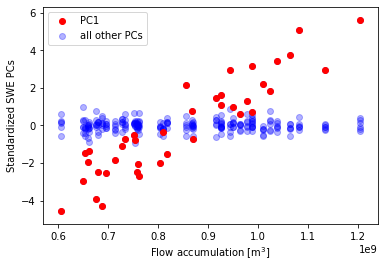

In [21]:
# Plot the predictors vs predictand training data to check relationships & uncertainties
SWE_column_names = [x for x in train_data.columns if 'Vol' not in x]
for c in SWE_column_names[1::]:
    plt.scatter(train_data['Vol'], train_data[c], color='b', alpha=.3)
all_pcs = plt.scatter(train_data['Vol'], train_data[PC_id_default], color='b', alpha=.3, label='all other PCs')
pc1 = plt.scatter(train_data['Vol'], train_data[PC_id_default], color='r', label=PC_id_default)
plt.ylabel('Standardized SWE PCs')
plt.xlabel('Flow accumulation [m$^3$]')
plt.legend(handles=[pc1,all_pcs]);

### Model fitting

In [22]:
# Fit the model on the training data
OLS_model = OLS_model_fitting(PC_id_default, train_data)

# Print a summary of the model
print(OLS_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    Vol   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     194.8
Date:                Tue, 25 Oct 2022   Prob (F-statistic):           2.55e-16
Time:                        10:25:05   Log-Likelihood:                -754.58
No. Observations:                  39   AIC:                             1513.
Df Residuals:                      37   BIC:                             1516.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.499e+08   1.01e+07     84.515      0.0

For a breakfown of what the regression results mean, see this [post](https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a).

### Deterministic forecasting

In [23]:
# Out-of-sample deterministic forecasting for the testing period
det_flow_fc = deterministic_forecasting(OLS_model, test_data)

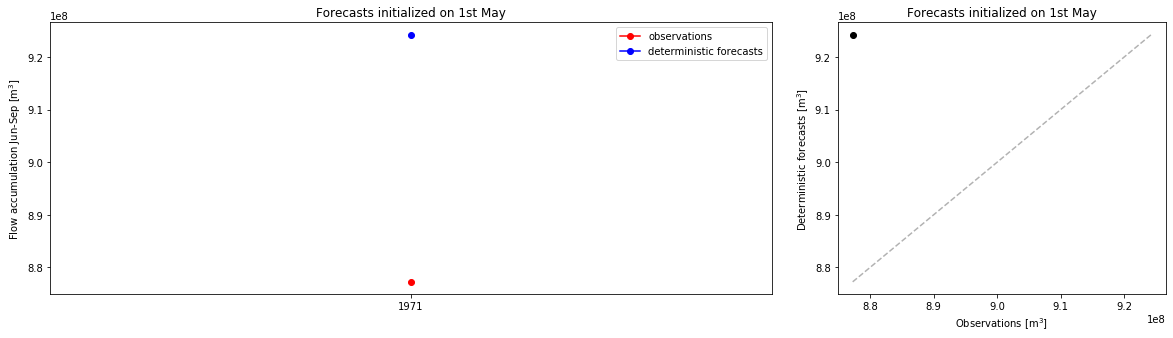

In [24]:
# Plot deterministic forecasts
deterministic_forecast_plots(flow_vol_testbasin_df['Vol_'+predictand_start_month_demo_name+'-'+predictand_end_month_demo_name], det_flow_fc, predictor_month=predictor_month_demo_name, predictand_start_month=predictand_start_month_demo_name, predictand_end_month=predictand_end_month_demo_name, units="m$^3$")

### Ensemble forecasts generation

In [25]:
# Generate forecasts for the training period to find errors between forecast means and observed values
# Note: These errors will be used for the ensemble forecast generation
det_flow_fc_train = deterministic_forecasting(OLS_model, train_data)

# Calculate errors between the forecast means and the observed values and their standard deviations
errors = det_flow_fc_train['Vol_fc_mean'].values - train_data['Vol'].values
std_dev = np.std(errors)

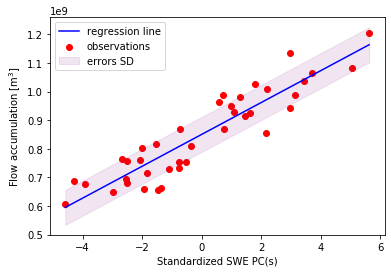

In [26]:
# Plot the predictor(s), predictand & the errors standard deviation for the training period
sorted_data = det_flow_fc_train.sort_values(by='Vol_fc_mean')
plt.scatter(train_data[PC_id_default], train_data['Vol'], color='r', label='observations')
plt.plot(train_data[PC_id_default].loc[sorted_data.index], sorted_data['Vol_fc_mean'], color='b', label='regression line')
plt.fill_between(train_data[PC_id_default].loc[sorted_data.index], sorted_data['Vol_fc_mean']+std_dev, sorted_data['Vol_fc_mean']-std_dev, color='purple', alpha=.1, label='errors SD')
plt.xlabel('Standardized SWE PC(s)')
plt.ylabel('Flow accumulation [m$^3$]')
plt.legend();

In [27]:
# Generate ensembles with an evenly (method='even') or randomly (method='random') spaced distribution
ens_flow_fc = ensemble_dressing(det_flow_fc, std_dev, ens_size=ens_size_default, method=method_ensemble_dressing_default)

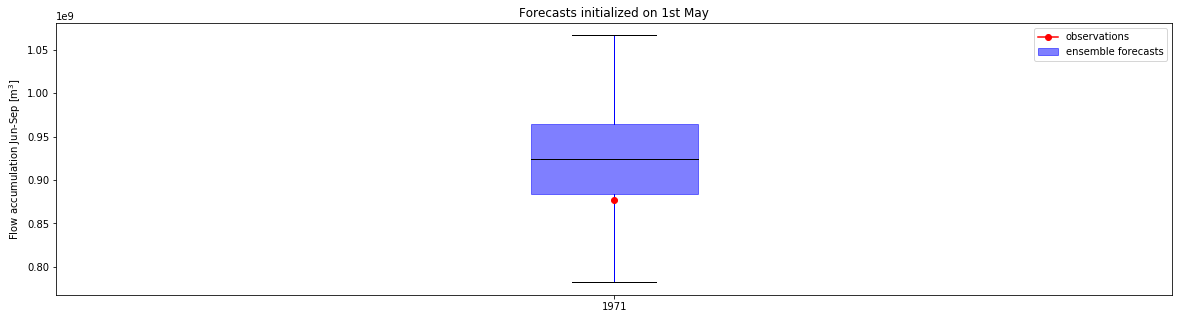

In [28]:
# Plot ensemble forecasts
ensemble_forecast_plots(flow_vol_testbasin_df['Vol_'+predictand_start_month_demo_name+'-'+predictand_end_month_demo_name], ens_flow_fc, predictor_month=predictor_month_demo_name, predictand_start_month=predictand_start_month_demo_name, predictand_end_month=predictand_end_month_demo_name, units="m$^3$")

## Generate all hindcasts

In [20]:
# Generate ensemble hindcasts
ens_fc_flow_volumes_testbasin = ensemble_forecasting(PCs_testbasin, flow_vol_testbasin_df, target_period_start_month, target_period_end_month, PC_id_default, ens_size=ens_size_default, method_ensemble_dressing=method_ensemble_dressing_default, min_overlap_years=min_overlap_years_default, method_traintest=method_traintest_default, nyears_leaveout=nyears_leaveout_default)

if ens_fc_flow_volumes_testbasin != None:
    ens_fc_flow_volumes_testbasin = ens_fc_flow_volumes_testbasin.assign_coords(Station_ID=flow_volumes_testbasin.Station_ID)

    display(ens_fc_flow_volumes_testbasin)
    
else:
    print('No hindcasts could be generated due to the non-overlap of predictands-predictors in time')

<xarray.Dataset>
Dimensions:       (Station_ID: 1, ens_member: 100, init_month: 9, year: 51)
Coordinates:
  * init_month    (init_month) int64 1 2 3 4 5 6 7 8 9
  * year          (year) int64 1941 1958 1959 1967 1968 ... 2011 2012 2013 2014
  * ens_member    (ens_member) int64 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100
    lat           (Station_ID) float64 51.17
    lon           (Station_ID) float64 -115.6
    Station_Name  (Station_ID) object 'BOW RIVER AT BANFF'
  * Station_ID    (Station_ID) object '05BB001'
Data variables:
    Vol_Jan-Sep   (year, ens_member, init_month) float64 nan nan nan ... nan nan
    Vol_Feb-Sep   (year, ens_member, init_month) float64 nan nan nan ... nan nan
    Vol_Mar-Sep   (year, ens_member, init_month) float64 nan nan nan ... nan nan
    Vol_Apr-Sep   (year, ens_member, init_month) float64 nan nan nan ... nan nan
    Vol_May-Sep   (year, ens_member, init_month) float64 nan nan nan ... nan nan
    Vol_Jun-Sep   (year, ens_member, init_month) float64 nan nan nan ... nan nan
    Vol_Jul-Sep   (year, ens_member, init_month) float64 nan nan nan ... nan nan
    Vol_Aug-Sep   (year, ens_member, init_month) float64 nan nan ... nan
    Vol_Sep-Sep   (year, ens_member, init_month) float64 nan nan ... 1.234e+08

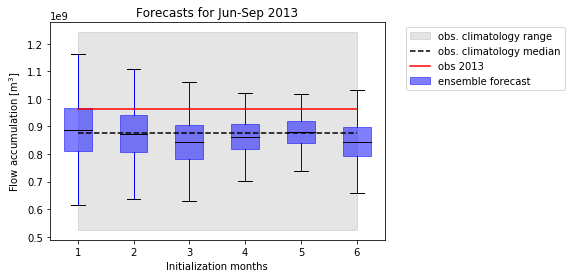

In [23]:
# Plot of hindcast evolution for a given year/event

init_months = np.arange(1,predictand_start_month_demo+1)

ens_fc = np.zeros((len(init_months),ens_size_default))

elem = 0

# Loop over forecast starting dates
for i in init_months:
    
    elem += 1

    initmo_name = datetime.datetime.strptime(str(init_months[i-1]), "%m").strftime("%b")
    
    # extract ensemble forecast
    ens_fc[i-1,:] = ens_fc_flow_volumes_testbasin['Vol_'+predictand_start_month_demo_name+'-'+predictand_end_month_demo_name].sel(year=year_demo, init_month=i)

# Observations climatology
obs_clim = flow_vol_testbasin_df['Vol_'+predictand_start_month_demo_name+'-'+predictand_end_month_demo_name].quantile([0, 0.5, 1])

# Plot
plt.fill_between(init_months, [obs_clim[0]]*len(init_months), [obs_clim[1]]*len(init_months), color='k', alpha=.1, label='obs. climatology range')
climo_range = mpatches.Patch(color='k', alpha=.1, label='obs. climatology range')
climo_med, = plt.plot(init_months, [obs_clim[0.5]]*len(init_months), color='k', ls='--', label='obs. climatology median')
obs, = plt.plot(init_months, [flow_vol_testbasin_df['Vol_'+predictand_start_month_demo_name+'-'+predictand_end_month_demo_name][year_demo]]*len(init_months), color='r', label='obs '+str(year_demo))

bp = plt.boxplot(ens_fc.T, patch_artist=True, zorder=1, whis=[0, 100], showfliers=False)
plt.setp(bp['boxes'], color='b', alpha=.5)
plt.setp(bp['whiskers'], color='b')
plt.setp(bp['medians'], color='k')
fc = mpatches.Patch(color='b', alpha=.5, label='ensemble forecast')
                  
plt.xticks(init_months)
plt.xlabel('Initialization months')
plt.title('Forecasts for '+predictand_start_month_demo_name+'-'+predictand_end_month_demo_name+' '+str(year_demo))
plt.ylabel('Flow accumulation [m$^3$]')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', handles=[climo_range, climo_med, obs, fc]);

# Store data & forecast model
This can then be read in this Notebook or called in any other Notebook of this workflow without having to re-run everything each single time. To read the stored data use: %store -r dataset_name

In [31]:
# Store data
%store ens_fc_flow_volumes_testbasin

Stored 'ens_fc_flow_volumes_testbasin' (Dataset)


In [29]:
# Store model: we can also save the model used to create these forecasts using the following code
# model_fit.save('OLS_model.pkl', remove_data=False)
# To load model back do: loaded = sm.load('OLS_model.pkl')